## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel#, ExpSquaredKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
#import warnings
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt

## Section 1: including and visualizing 13 TeV dataset

In [3]:
xvalO = np.load("savedOutputs/xvalO.npy")
yvalO = np.load("savedOutputs/yvalO.npy")
xerrO = np.load("savedOutputs/xerrO.npy")
xlowO = np.load("savedOutputs/xlowO.npy")
xval = np.load("savedOutputs/xval.npy")
yval = np.load("savedOutputs/yval.npy")
xerr = np.load("savedOutputs/xerr.npy")

xlowO = list(xlowO)
toyList = np.load("savedOutputs/toyList.npy")
lumiToyDict = np.load("savedOutputs/lumiToyList.npy")
#meanGPnom = np.load("savedOutputs/initialGPfit.npy")
fixedHyperparams = np.load("savedOutputs/fixedHyperparams.npy")
sigToys = np.load("savedOutputs/signalToys.npy")
sigToysO = np.load("savedOutputs/signalToysO.npy")

##longer xvals

standardParamSets = [(1500,2000,250), (750 ,2500, 250), (200, 3000, 250), (75, 3500, 250), (50, 4000, 250), 
             (25, 4500, 250), (20, 5000, 250), (15,5500, 250), (15, 6000,250)]

In [4]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

def addZeros(data, xtoy):
    for ik, k in enumerate(xvalO):
        if ik <len(xtoy):
            if k == xtoy[ik]:
                #print "same", k, ik
                continue
            else:
                #print "diff", k, ik, len(xtoy)
                if ik <= len(xtoy):
                    xtoy = np.insert(xtoy, ik, k)
                    #print xtoy
                    data = np.insert(data, ik, 0)
        else:
            xtoy = np.append(xtoy, k)
            data = np.append(data, 0)
    return data, xtoy

### This set has all bins that equal 0 removed. These 0 points really bias the GP

## GP SIGNAL FIGURE 8

In [5]:
def makePrettyPlots_sb(xs_l, xs, ys_b, ys_sb, bkgs, bkgs_l, bkgsigs,xlow, title, ymax = 2e5):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys_sb, marker='o', ls='None', yerr = np.sqrt(ys_sb), c='black', markersize=10, label="data+signal")
    bkg1Plot, = ax1.plot(xs_l, bkgs_l, color='g', linewidth=3.0, label="bkg only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='b', linewidth=3.0, label="bkg+signal")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.09, ymax])
    ax1.tick_params(axis='y', labelsize=20)

    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys_sb, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlow,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    h1.fillcolor = 'green'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    #print h1[:]
    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    ax2.set_ylabel('Significance', fontsize=15)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.annotate("data+signal vs bkg",(4020,-3.5), fontsize=15)
    #ax2.set_ylim([-2, 8])

    #print ys_sb_s[-10:]
    #print bkgs[-10:]
    #print zvals_1[-10:]
    #print xlow_l[-10:]
    
    zvals_2, chi2_2 = calcSignificance(ys_sb, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlow,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'blue'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax3.set_ylabel('Significance', fontsize=15)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=20)
    ax3.tick_params(axis='x', labelsize=20)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.annotate("data+signal vs bkg+signal",(4020,-3.5), fontsize=15)
    

    zvals_3, chi2_3 = calcSignificance(ys_b, bkgs)
    print "chi2 bkg+signal", chi2_3
    h3 = Hist(xlow,markersize=0)
    for x in range(len(zvals_3)):
        if zvals_3[x] == np.inf or zvals_3[x] == -np.inf: h3[x] = 20
        else: h3[x] = zvals_3[x]  
    h3.fillstyle = 'solid'
    h3.fillcolor = 'red'
    h3.linecolor = 'black'
    h3.linewidth = 1
    h3.Draw("histX0")
    rplt.bar(h3, xerr=None, yerr=None, axes=ax4)
    ax4.axhline(0, color='black', lw=1)
    ax4.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax4.set_ylabel('Significance', fontsize=15)
    ax4.set_xscale('log')
    ax4.tick_params(axis='y', labelsize=20)
    ax4.tick_params(axis='x', labelsize=20)
    ax4.set_ylim([-5, 5])
    ax4.set_xlim([1000, 7500])
    ax4.annotate("data vs bkg",(4020,-3.5), fontsize=15)
    
    ax4.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax4.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax4.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()
    
def makePrettyPlots_signalOnly(xs, ys, bkgs, title, ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color='g', linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])

    
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  

    h1.fillstyle = 'solid'
    h1.fillcolor = 'blue'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

In [6]:
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel, mean=Mean(p0=p0, p1=p1, p2=p2), fit_mean = True)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y)
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [7]:
def model_gp(params, t, xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

In [8]:
class logLike_gp_fitgpsig:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(100):
        init0 = np.random.random() * 3000.
        init1 = np.random.random() * 3000.
        init2 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, 
                  error_A = 1., error_mass = 1., error_tau = 1.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500))
        fit = m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args   
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [9]:
def basicPlot(xs, ys, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(10,10))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10)
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_ylim([0.01, 2e6])
    
    ax1.set_xscale('log')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)

In [10]:
def peak(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    slope=0.5
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center: 
            output[i]=(slope*c-slope*center+amp)#*xerr[i] #no xerr
        if c > center and c < center+width:
            #print (-slope*c+slope*center+amp)
            output[i]=(-slope*c+slope*center+amp)#*xerr[i]
    #print output
    output = [s if s > 0 else 0 for s in output]
    return output

In [11]:
def square(t, amp, center, width, xerr):
    output = np.zeros(len(t))
    for i, c in enumerate(t):
        if c < center-width or c > center-width: pass
        if c > center-width and c < center+width: output[i]=amp#*xerr[i]
    return output

In [12]:
def gaus(x, amp, center, width, xerr):
    return amp*(np.exp(-(x-center)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xerr

In [13]:
def model_5param(t, terr): 
    #because I already fit the 13TeV 3.6 fb-1 dijet dataset and here were the parameters
    p0, p1, p2, p3, p4 = (0.25, 9.8, -3.5, 0.61, 0.078)
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2+p3*np.log(t/sqrts)+p4*np.log(t/sqrts)**2))*terr#**np.append(np.diff(t), np.diff(t)[-1])

def make_truth():
    return np.random.poisson(model_5param(truth_steps, truth_step_size))

def make_smeared():
    return np.random.poisson(model_5param(smeared_steps, smeared_step_size))

truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
dataset = make_truth()


basicPlot(truth_steps, dataset, "Smooth dataset", col='g')


signal = peak(truth_steps, 200, 3000, 250, truth_step_size)
basicPlot(truth_steps, signal, "Smooth dataset", col='g')
signal = square(truth_steps, 750 ,2500, 250, truth_step_size)
basicPlot(truth_steps, signal, "Smooth dataset", col='g')
smeared_counts, noisy_smeared_counts = smear(np.zeros(len(dataset)), signal)
basicPlot(smeared_steps, smeared_counts, "Smooth dataset", col='g')

gaussian_width = 10.
smeared_steps=np.logspace(np.log10(1100), np.log10(7000), 75)
smeared_step_size = np.append(np.diff(smeared_steps), np.diff(smeared_steps)[-1])
smeared_steps_low = smeared_steps-smeared_step_size/2.
#print smeared_steps
#print smeared_step_size
#print smeared_steps_low

In [14]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smearO(s, signal_shape):
    smeared_counts=np.zeros(len(xvalO))
    for xi, x in enumerate(xvalO):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [15]:
truth_steps = np.logspace(np.log10(900), np.log10(8000), 200)
truth_step_size = np.append(np.diff(truth_steps),np.diff(truth_steps)[-1]) 
def smear(s, signal_shape):
    smeared_counts=np.zeros(len(xval))
    for xi, x in enumerate(xval):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    smeared_counts = [s if s > 0 else 0 for s in smeared_counts]
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

def smear(s, signal_shape):
    smeared_counts=np.zeros(len(smeared_steps))
    for xi, x in enumerate(smeared_steps):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, truth_step_size*2.)
        smeared_counts[xi]=np.sum((s+signal_shape)*gaus)
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

from george.modeling import ModelingMixin
class Mean(ModelingMixin):
    def get_value(self, t):
        sqrts = 13000.
        return (self.p0 * (1.-t/sqrts)**self.p1 * (t/sqrts)**(self.p2))*np.append(np.diff(t), np.diff(t)[-1])

In [82]:
def makeGP(ycounts, xxs, xxserr):
    Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams #best_fit_gp 
    lnProb = logLike_gp_fitgpsig(xxs, ycounts, xxserr)
    bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, True)
    if np.isinf(bestval): 
        print "failed"
        return np.inf, np.inf, np.inf, np.inf
        
    A, mass, tau = best_fit_new 
    print "A, mas, tau", A, mass, tau
    
    kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
    kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

    
    kernel = kernel1 + kernel2
    gp = george.GP(kernel)
    gp.compute(xxs, np.sqrt(ycounts))
    meanGPp = gp.predict( ycounts - model_gp((p0,p1,p2),xxs, xxserr), xxs)[0]
    meanGP = meanGPp + model_gp((p0,p1,p2),xxs,xxserr)

    gp2 = george.GP(kernel)
    gp2.compute(xxs, np.sqrt(ycounts))
    K1 = kernel1.get_value(np.atleast_2d(xxs).T)
    mu1 = np.dot(K1, gp2.solver.apply_inverse(ycounts- model_gp((p0,p1,p2),xxs, xxserr))) + model_gp((p0,p1, p2),xxs,  xxserr)
    K2 = kernel2.get_value(np.atleast_2d(xxs).T)
    mu2 = np.dot(K2, gp2.solver.apply_inverse(ycounts- model_gp((p0,p1,p2),xxs, xxserr)))

    
    return meanGP, mu1, mu2, (A, mass, tau)

In [12]:
class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf

def fit_gp_minuit(lnprob, Print = True):
    passedFit = False
    minLLH = np.inf
    best_fit_params = (0, 0, 0, 0, 0, 0, 0, 0)
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1., error_decay = 0.1, error_length = 0.1, error_power = 0.1, 
                   error_sub = 0.1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (100., 1e15), limit_decay = (0, 500), limit_length = (0, 300), 
                   limit_power = (-200, 200), limit_sub = (0, 1000), limit_p0 = (0,10), 
                   limit_p1 = (-20, 20), limit_p2 = (-20,0)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
        
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0, 0, 0, 0, 0, 0, 0, 0)
        numRetries+=1

    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params



dataset = make_smeared()
lnProb = logLike_gp(smeared_steps,dataset,smeared_step_size)
minimumLLHgp, best_fit_gp = fit_gp_minuit(lnProb, False)
print best_fit_gp
Amp, decay, length, power, sub, p0, p1, p2 = best_fit_gp
print fixedHyperparams
kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

gp = george.GP(kernel1)
gp.compute(smeared_steps, np.sqrt(dataset))
meanGPp = gp.predict( dataset - model_gp((p0,p1,p2),smeared_steps, smeared_step_size), smeared_steps)[0]
meanGP = meanGPp + model_gp((p0,p1,p2), smeared_steps, smeared_step_size)
makePrettyPlots_sb(smeared_steps, dataset, dataset, meanGP, meanGP,list(smeared_steps_low), "", ymax = 2e5)
#basicPlot(smeared_steps, dataset, "Smooth dataset", col='g')

parameters (1500, 2000, 300)
(1.0063039353832894, 1012.1296587886637, 100.07558272925097)
(2737.4750348697266, 2178.3415040244668, 139.21015945602005)
(2727.1376627926984, 2178.815793866118, 138.81186507399454)
(2735.962883570421, 2178.8155602356514, 138.99394971302684)
(2728.277508494363, 2178.9340286571146, 139.04408745004764)
A, mass, tau 2728.27750849 2178.93402866 139.04408745


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.3915571617
chi2 bkg+signal nan


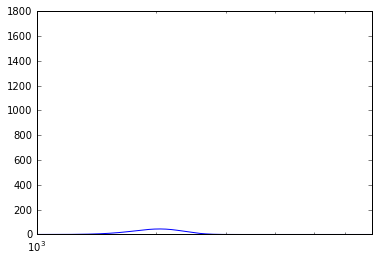

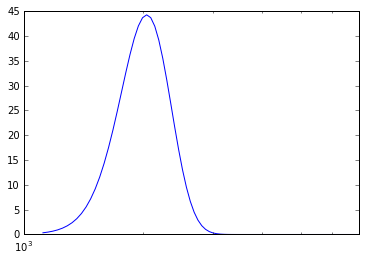

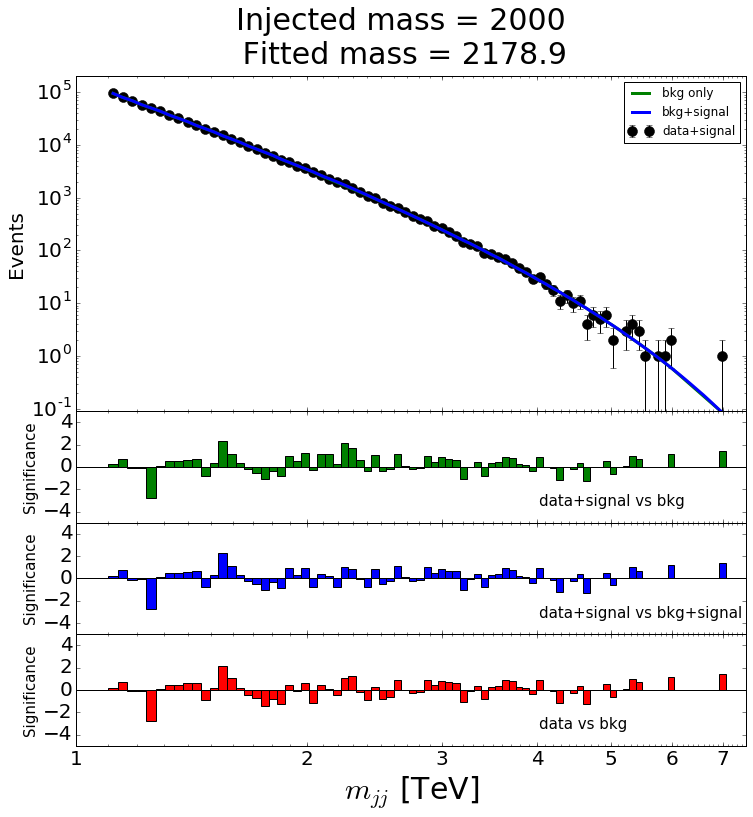

chi2 696039873.812


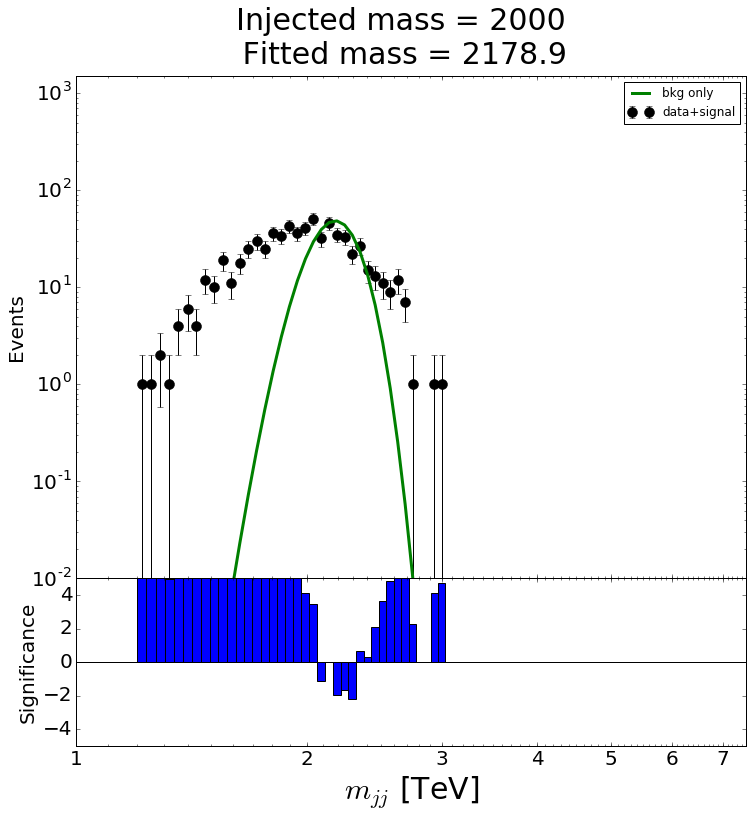

parameters (800, 2500, 250)
(1.8488196487308883, 1000.0000697993244, 127.55769210181299)
(1.000555573093966, 1000.0000996448443, 118.33031996016388)
(3151.392325691694, 1777.8070031605644, 100.00001031295199)
(873.9731309105034, 2574.3110441586155, 314.22191101306)
(873.805284020567, 2574.1409021547356, 314.26514583873893)
(874.2053829575184, 2574.252151690597, 314.20280880640905)
(873.9761202735482, 2574.223472099323, 314.219007295344)
A, mass, tau 873.976120274 2574.2234721 314.219007295
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 65.1302812824
chi2 bkg+signal nan


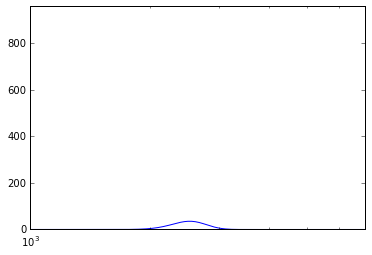

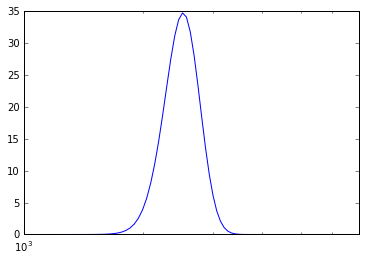

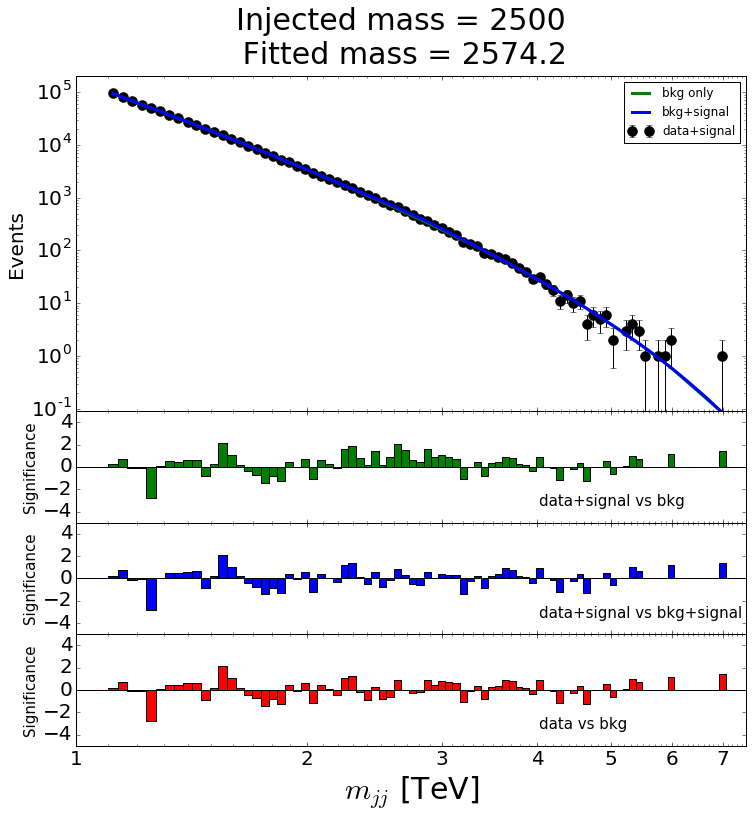

chi2 42.3779849373


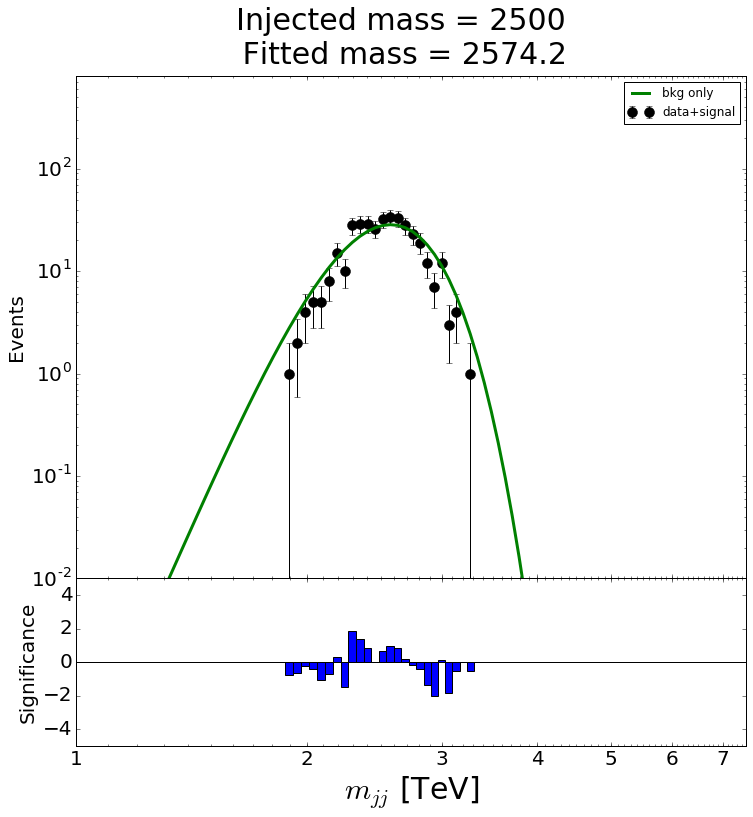

parameters (500, 3000, 250)
(707.1990166145665, 3033.8609124096465, 300.09446768626617)
(703.4021529151596, 3034.058016366179, 299.85599044696454)
(703.8516978924622, 3034.0027829881255, 299.80773380066034)
(704.6170461834237, 3034.069683125849, 299.70630822720216)
(704.2072315729976, 3034.044351044503, 299.7265750667701)
(704.0586452850624, 3034.070894922446, 299.7372389090416)
A, mass, tau 704.058645285 3034.07089492 299.737238909
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 66.717951477
chi2 bkg+signal nan


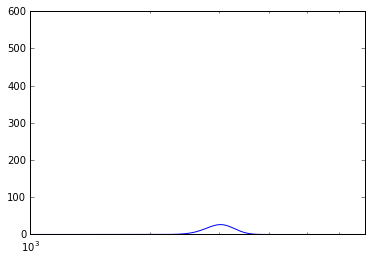

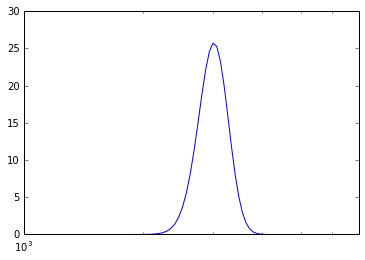

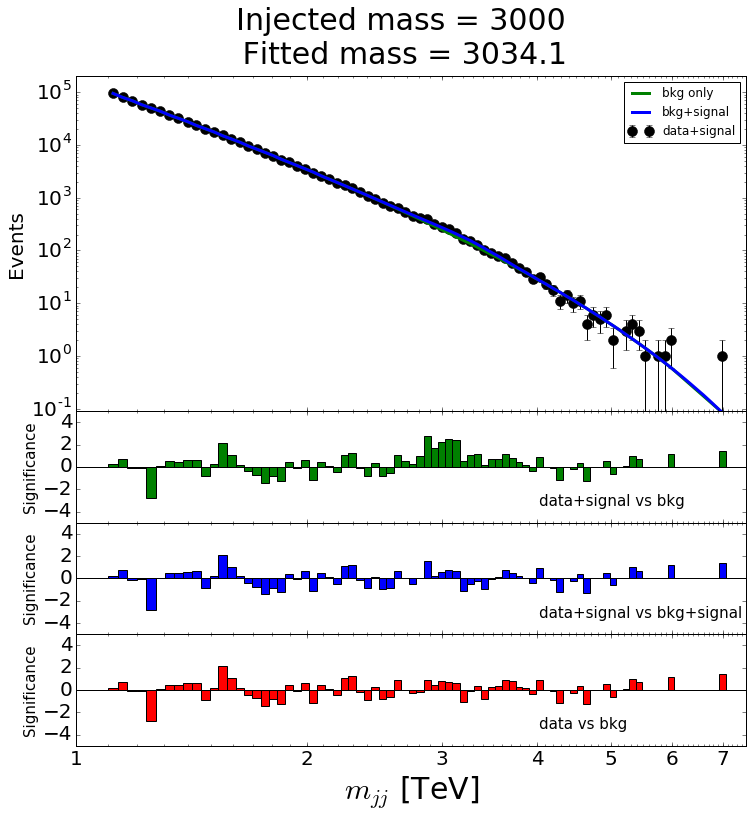

chi2 29.745678146


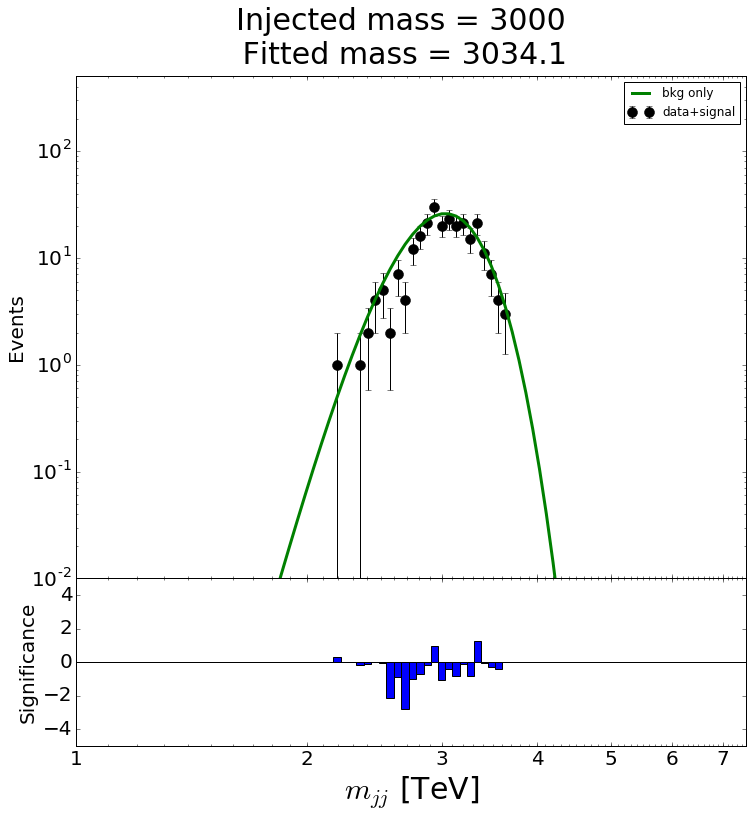

parameters (300, 3500, 250)
(3250.1489561298476, 1779.2988414114263, 100.00000222332797)
(416.75724309662206, 3525.8738616049677, 274.2307567494251)
(416.99251103066064, 3525.8789690824165, 274.23483899503043)
(417.0501868680134, 3525.882390050529, 274.2264770418457)
A, mass, tau 417.050186868 3525.88239005 274.226477042
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 71.539857381
chi2 bkg+signal nan


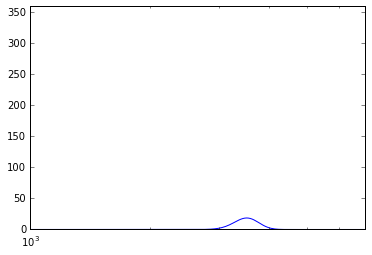

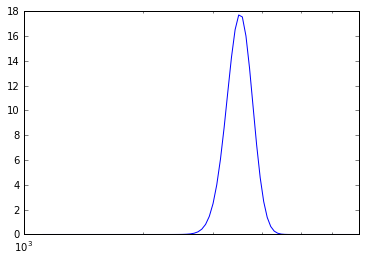

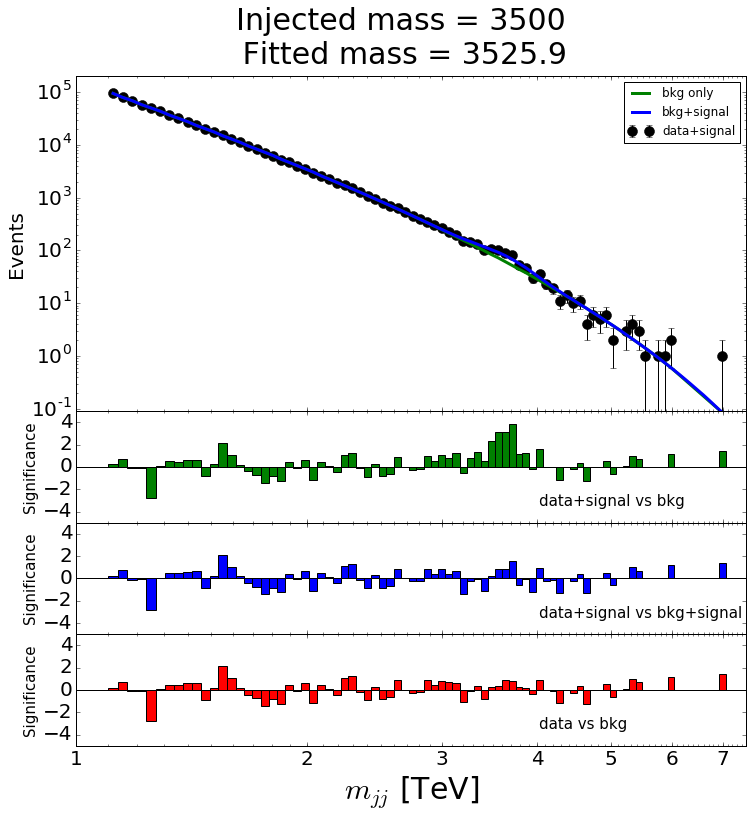

chi2 26.3535262465


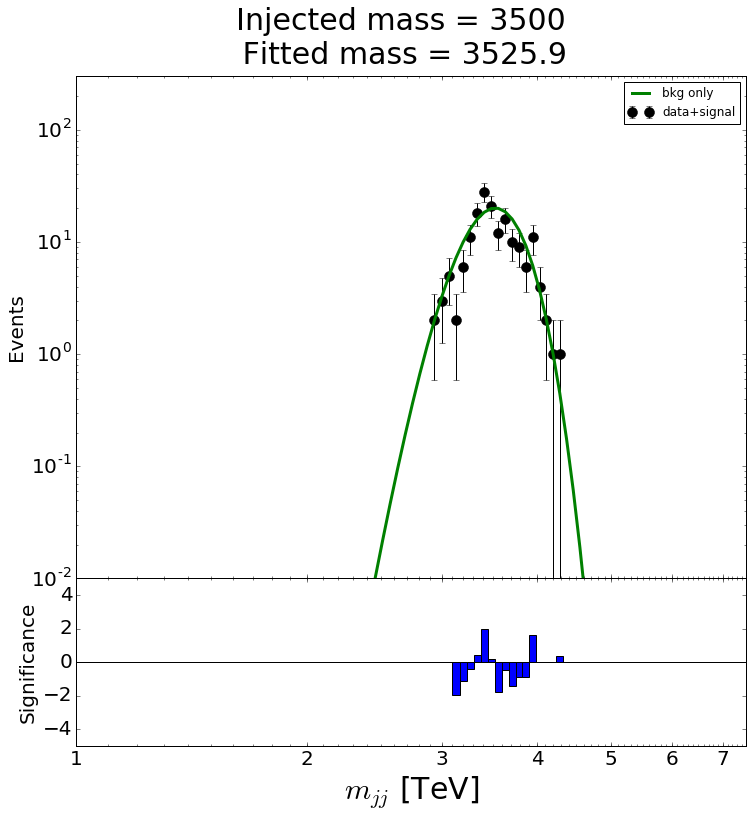

parameters (100, 4000, 250)
(3235.7006361872172, 1779.3536357294552, 100.00000964633817)
(3236.433411346976, 1779.3127910350086, 100.00000006581149)
(3235.8574286377625, 1779.3438013001191, 100.00000000811194)
A, mass, tau 3235.85742864 1779.3438013 100.000000008
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 75.3058841366
chi2 bkg+signal nan


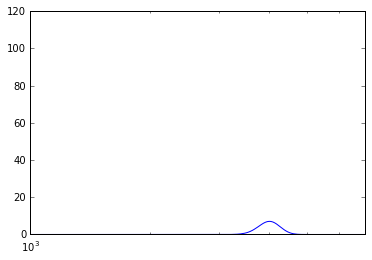

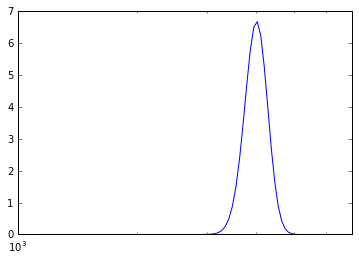

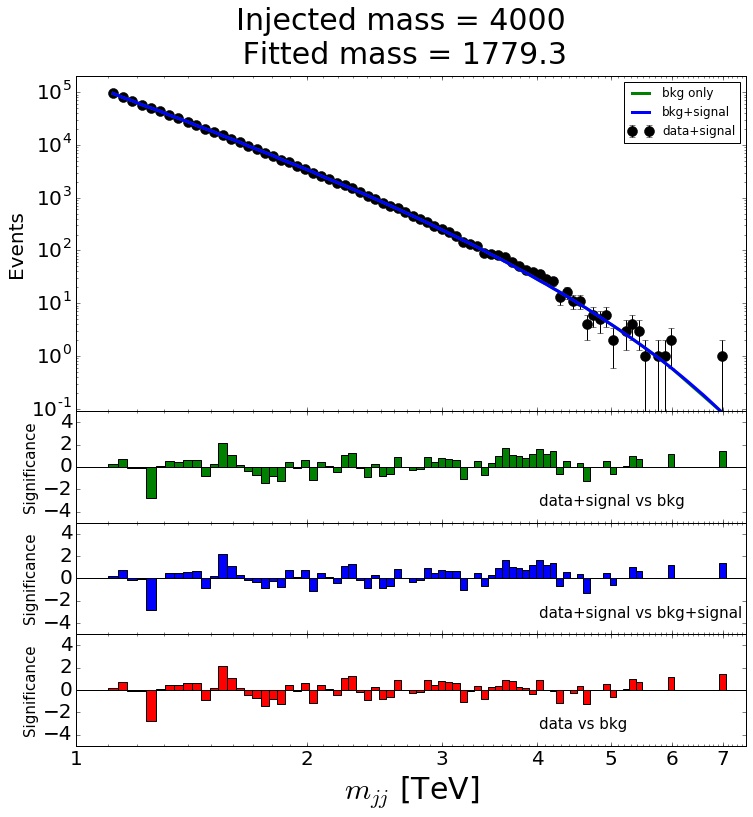

chi2 nan


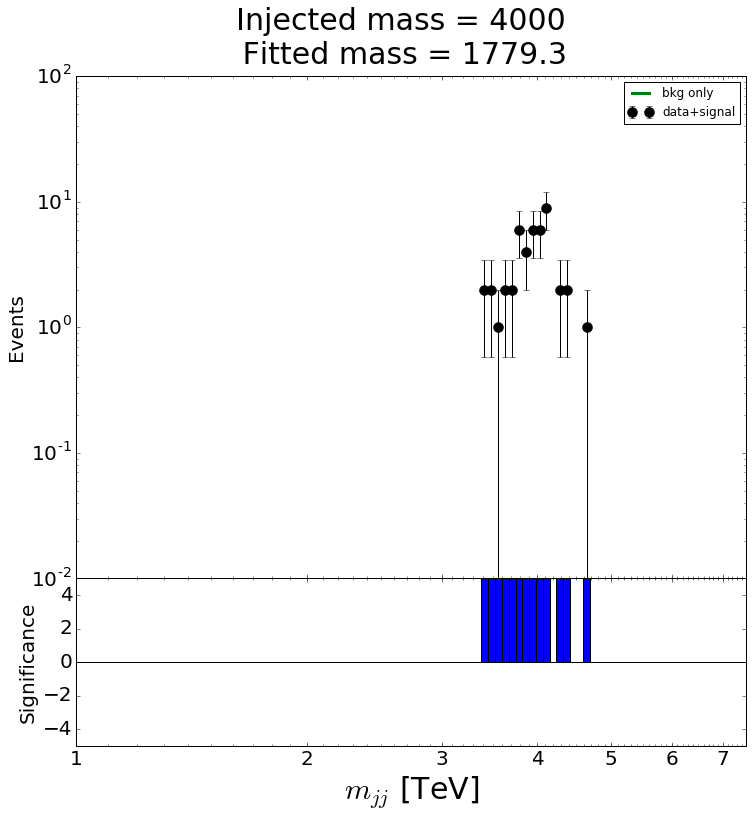

parameters (75, 4500, 250)
(3657.155107109736, 1509.99955384339, 100.00017214791848)
(3198.3915398559, 1779.2912690684975, 100.00000063899958)
(3225.0595832337617, 1779.413080847085, 100.00042224966617)
(3232.262958811655, 1779.3550992422815, 100.00000035669893)
(8.775480328935398, 4273.8907885916, 499.96473577917953)
(40.02862124814539, 4503.781555789062, 111.95030264366075)
A, mass, tau 40.0286212481 4503.78155579 111.950302644


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in double_scalars


chi2 bkg+signal mu=0 nan
chi2 bkg+signal 72.3506620013
chi2 bkg+signal nan


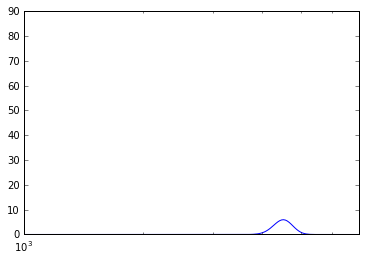

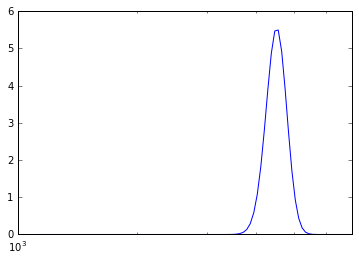

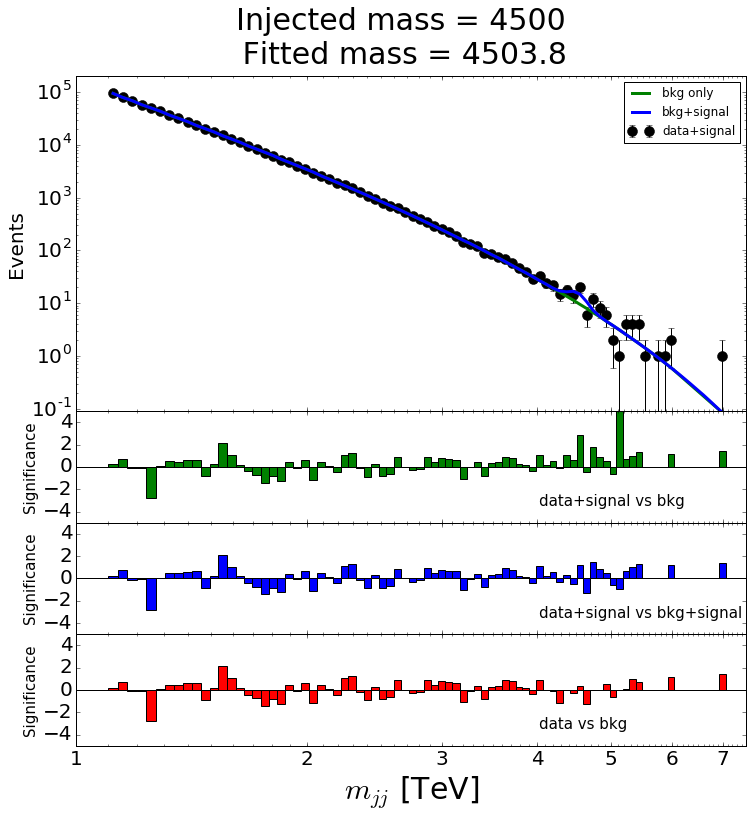

chi2 1831580.01851


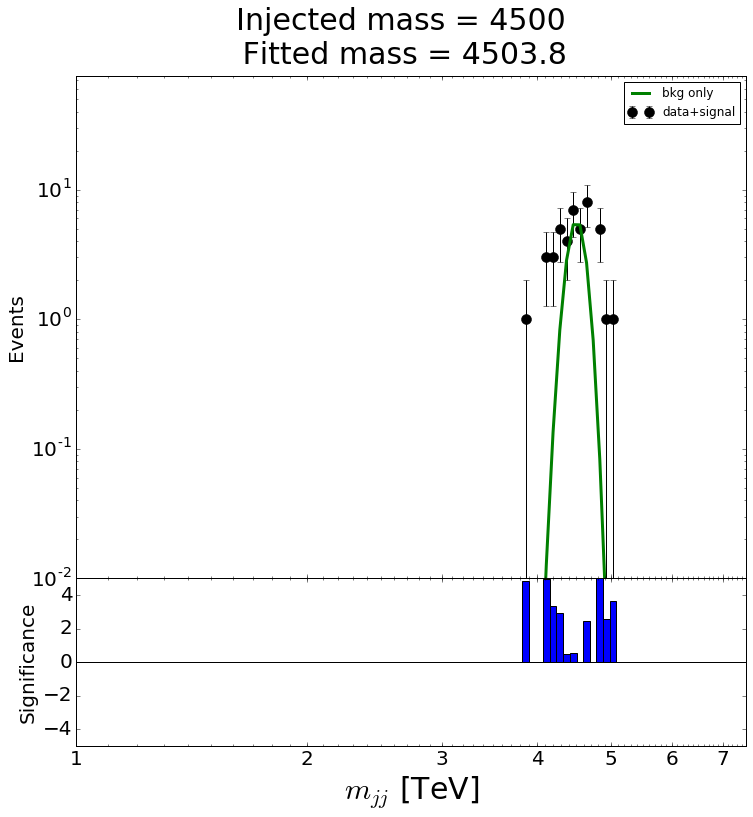

parameters (50, 5000, 250)
(1.1244008632055675, 1000.0000000003005, 100.0000000000002)
(3166.14542846005, 1779.7743369796071, 100.00006500437064)
(3237.167364703994, 1779.308329099314, 100.00000006806286)
(22.82493123918913, 5140.296738034773, 226.62676640904618)
(22.858667151015315, 5140.390170012978, 226.5276821638849)
A, mass, tau 22.858667151 5140.39017001 226.527682164
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 64.526276947
chi2 bkg+signal nan


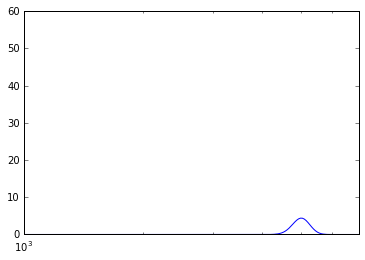

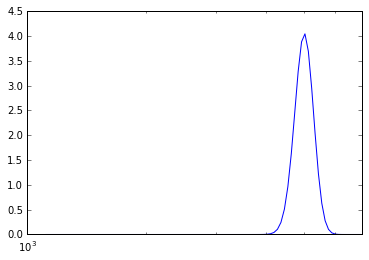

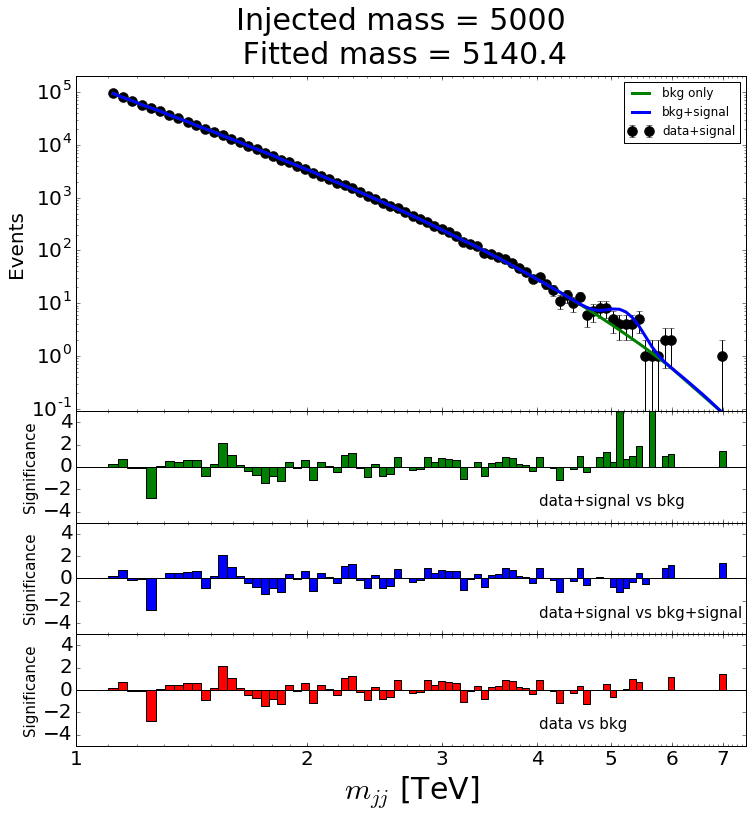

chi2 10.2680792001


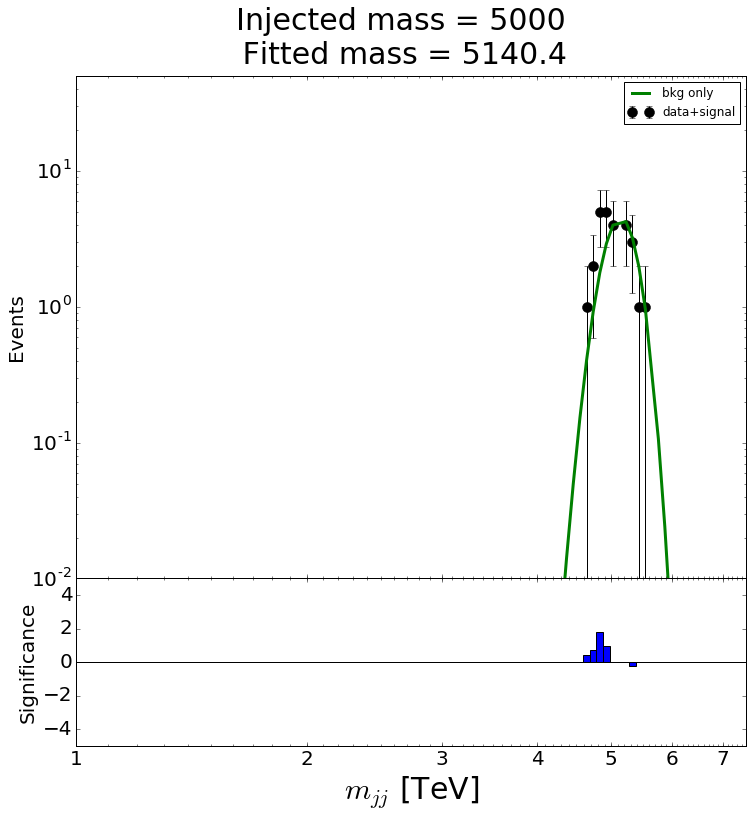

parameters (25, 5500, 250)
(1.7294174434969112, 1000.0000807967663, 132.45577738459343)
(1.097449791143829, 1000.8618255629558, 100.15337505630815)
(80.56197165894994, 2975.3251476385876, 100.00259375494491)
(3230.304278658779, 1779.4243512716266, 100.00072710006486)
(3214.5219421840898, 1779.3012842660455, 100.0)
(3235.4469413027264, 1779.3999807563023, 100.00012286332051)
(3235.4227161594936, 1779.3351111016277, 100.00000123971908)
(3235.61627898214, 1779.3320366896137, 100.00000049347952)
(9.444463732989394, 5348.701201785116, 100.00005724048138)
A, mass, tau 9.44446373299 5348.70120179 100.00005724
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 72.2805137312
chi2 bkg+signal nan


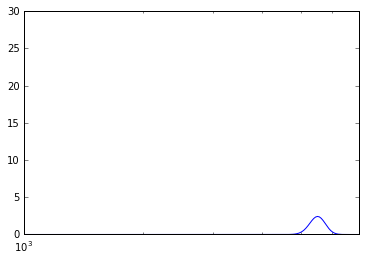

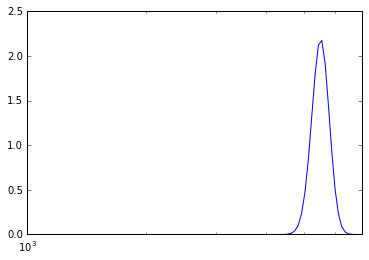

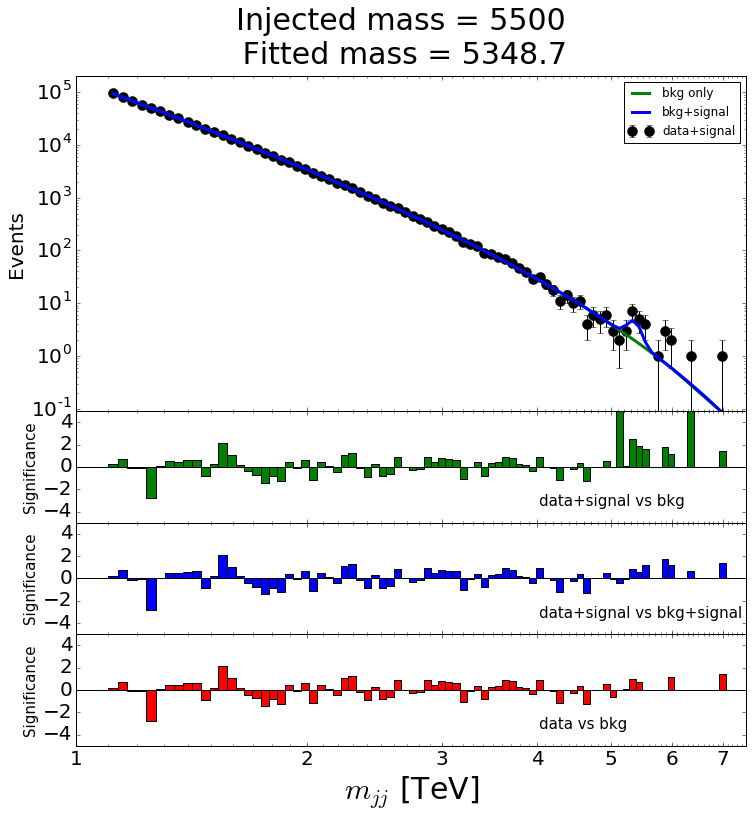

chi2 nan


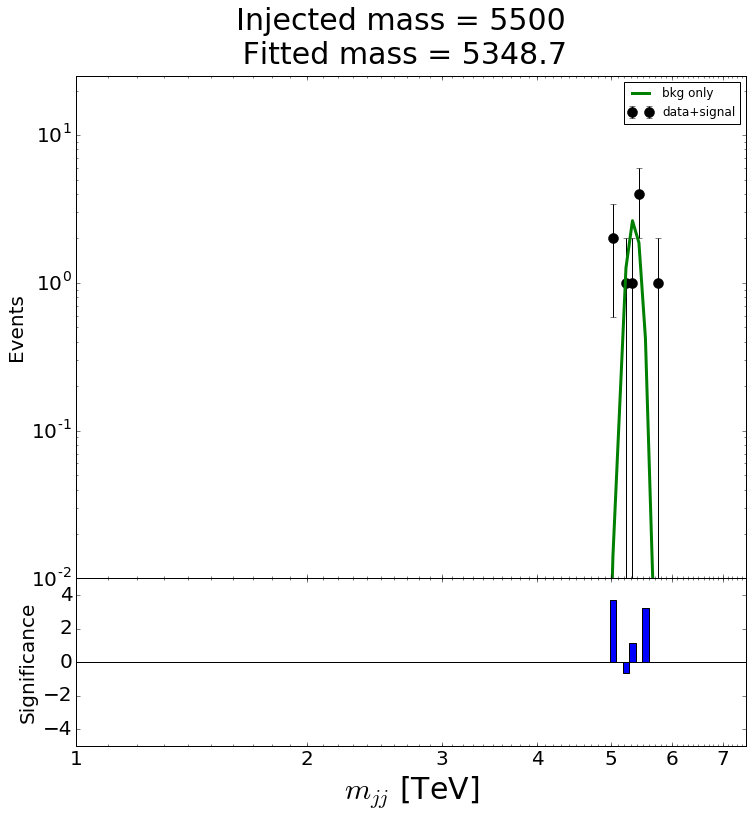

parameters (15, 6000, 250)
(3231.944385016446, 1779.3488518425527, 100.00000006880614)
(3237.4435293308666, 1779.3303721524776, 100.0000000300066)
A, mass, tau 3237.44352933 1779.33037215 100.00000003
chi2 bkg+signal mu=0 nan
chi2 bkg+signal 115.091773536
chi2 bkg+signal nan


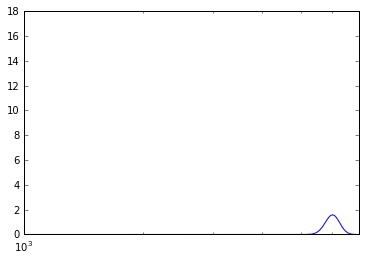

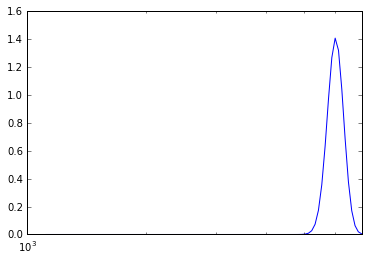

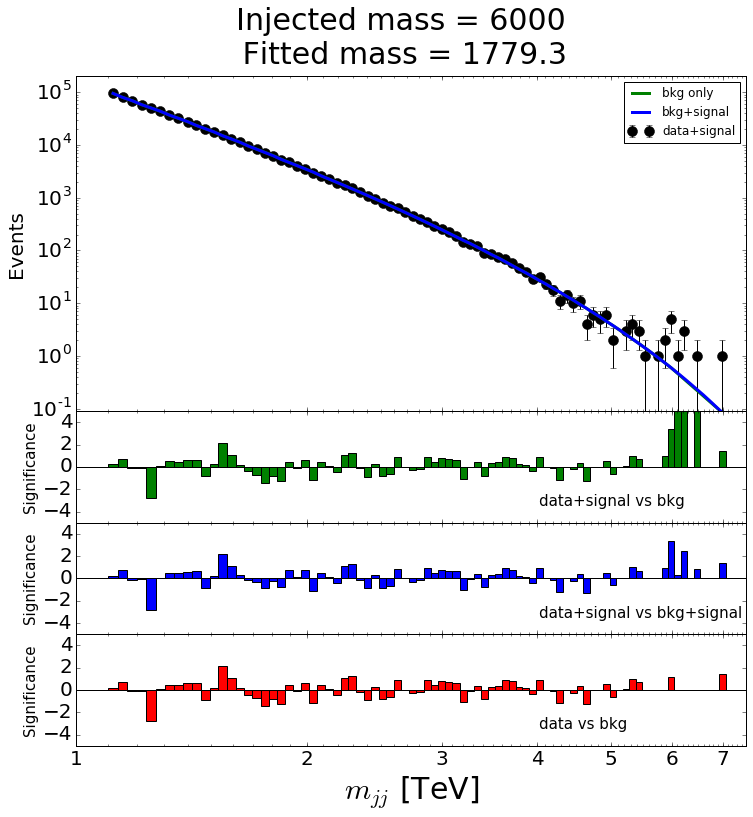

chi2 nan


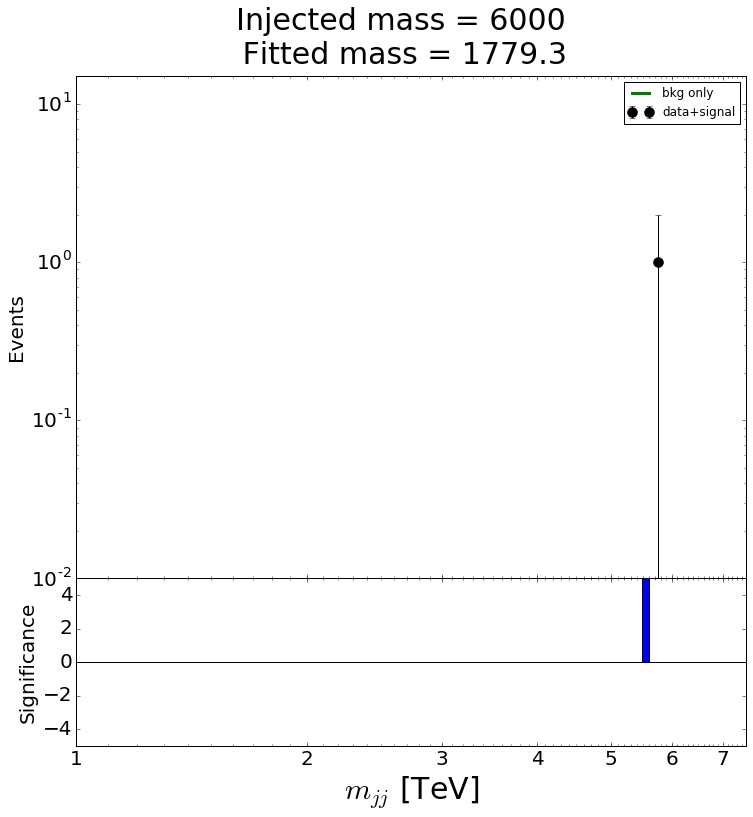

In [20]:
aa={}
mm={}
ww={}
standardParamSets = [(1500,2000,300), (800 ,2500, 250), (500, 3000, 250), (300, 3500, 250), (100, 4000, 250), 
                     (75, 4500, 250), (50, 5000, 250), (25,5500, 250), (15, 6000,250)]
#standardParamSets = [(200,2000,300), (100 ,2500, 250), (75, 3000, 250), (60, 3500, 250), (55, 4000, 250), 
#                     (45, 4500, 250), (40, 5000, 250), (25,5500, 250), (15, 6000,250)]
#standardParamSets = [(100,2000,300), (50 ,2500, 250), (30, 3000, 250), (20, 3500, 250), (15, 4000, 250), 
#                     (10, 4500, 250), (9, 5000, 250), (5,5500, 250), (4, 6000,250)]
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    aa[m]=[]
    mm[m]=[]
    ww[m]=[]

    for i in range(1):
        #dataset = make_truth()
        ytoy, xtoy, xtoyerr = removeZeros(yvalO)
        xtoylow = list(xtoy-xtoyerr/2.)
        
        signal = gaus(truth_steps, n, m, w, truth_step_size)
        #signal = peak(truth_steps, n, m, w, truth_step_size)
        #signal = square(truth_steps, n, m, w, truth_step_size)
        plt.figure()
        plt.plot(truth_steps, signal)
        plt.xlim([1000,7000])
        plt.ylim([0,n*1.2])
        plt.xscale('log')
        
        #dataset = make_smeared()
        
        smeared_counts, noisy_smeared_counts = smear(np.zeros(len(truth_steps)), signal)
        ydata = ytoy + noisy_smeared_counts
        smeared_countsO, noisy_smeared_countsO = smearO(np.zeros(len(truth_steps)), signal)
        ydataO = yvalO + noisy_smeared_countsO
        #signal = peak(xvalO, n, m, w, xerrO)
        
        plt.figure()
        plt.plot(xvalO, smeared_countsO)
        plt.xlim([1000,7000])
        plt.xscale('log')
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        A, mass, tau = best_fit_new 
        aa[m].append(A)
        mm[m].append(mass)
        ww[m].append(tau)
        print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_gp((p0,p1,p2),xvalO,xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_gp((p0,p1, p2), xtoy, xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr)))
        
        #print "mu", mu1
        #print "yvalO", xvalO
        newy, newx = addZeros(mu1, xtoy)
        #print newx
        #print xvalO
        '''
         #smeared_counts, noisy_smeared_counts = smear(dataset, signal)


        print noisy_smeared_counts
        #basicPlot(smeared_steps, smeared_counts+dataset, "Smooth dataset", col='g')
        #meanGP, mu1, mu2, signalParams = makeGP(noisy_smeared_counts+dataset, smeared_steps, smeared_step_size)
        meanGP, mu1, mu2, signalParams = makeGP(dataset, xvalO, xerrO) #noisy_smeared_counts+
        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        plt.figure()
        plt.plot(xvalO, noisy_smeared_counts + dataset - model_gp((p0,p1,p2),xvalO, xerrO))
        plt.plot(xvalO, dataset - model_gp((p0,p1,p2),xvalO, xerrO), c='r')
        plt.xscale('log')
        
        #plt.figure()
        #plt.plot(xvalO, noisy_smeared_counts+dataset)
                    
        #print meanGP
        if not any(meanGP):continue
        A, M, W = signalParams
        print signalParams
        aa[m].append(A)
        mm[m].append(M)
        ww[m].append(W)
        '''
#ys_b_s, ys_sb, ys_sb_s
        label="Injected mass = "+str(m)+"\n Fitted mass = "+str(round(mass,1))
        #makePrettyPlots_sb(smeared_steps, dataset, dataset+smeared_counts, mu1, meanGP, list(smeared_steps_low), label)
        #makePrettyPlots_sb(xval, xvalO, yval, ydataO, ydata, mu1, meanGP, list(xtoylow), list(xlowO), label)
        makePrettyPlots_sb(xval, xvalO, yvalO, ydataO, newy, mu1, meanGP, list(xlowO), label)
        
        #label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
        makePrettyPlots_signalOnly(xval, noisy_smeared_counts, mu2, label, n)
        

In [23]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa[m]), np.mean(mm[m]), np.mean(ww[m])
    

parameters (1500, 2000, 250)
15067.0643645 2036.92513952 242.884387149
parameters (750, 2500, 250)
5074.67093663 2516.29421701 257.851477881
parameters (200, 3000, 250)
709.448613717 3210.98923313 225.746718275
parameters (75, 3500, 250)
726.029940549 3562.88758486 191.053994807
parameters (50, 4000, 250)
1944.14443984 3868.12108777 183.744751774
parameters (25, 4500, 250)
3422.21628296 3719.65437962 150.635175257
parameters (20, 5000, 250)
4551.46933484 3785.34237168 164.28300932
parameters (15, 5500, 250)
1090.14827872 4336.76433285 194.476684844
parameters (15, 6000, 250)
1892.18368669 4374.46668927 202.411164576


In [24]:
class logLike_gp_fitgpsig2:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, A, mass, tau, A1, w1):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            #print "hi", model_gp((p0,p1,p2), self.x, self.xerr)
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr) - sig_model(self.x, A1, mass, w1, self.xerr))
        except:
            return np.inf  
        
def fit_gp_fitgpsig_minuit2(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0)
    for i in range(100):
        init0 = np.random.random() * 500.
        init1 = np.random.random() * 4000.
        init2 = np.random.random() * 200.
        init3 = np.random.random() * 500.
        #init4 = np.random.random() * 4000.
        init4 = np.random.random() * 200.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  A = init0, mass = init1, tau = init2, A1 = init3, w1 = init4,
                  error_A = 100., error_mass = 10., error_tau = 5., error_A1 = 100., error_w1 = 5.,
                  limit_A = (1, 1e5), limit_mass = (1000, 7000), limit_tau = (100, 500), limit_A1 = (1, 1e5), 
                  limit_w1 = (100, 500))
        m.migrad()
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

In [27]:
chi_GP_sig2={}
chi_GP_bkg2={}
chi_GP_sb2={}
aa2={}
mm2={}
ww2={}
print fixedHyperparams
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet

    chi_GP_sig2[m]=[]
    chi_GP_bkg2[m]=[]
    chi_GP_sb2[m]=[]
    aa2[m]=[]
    mm2[m]=[]
    ww2[m]=[]
    for itoy, toy in enumerate(toyList[:10]):
        if itoy%10 ==0: print itoy
        
        ytoy, xtoy, xtoyerr = removeZeros(toy)
        xtoylow = list(xtoy-xtoyerr/2.)

        signalTemplate = sigToys[()][m][itoy]
        ydata = ytoy + signalTemplate

        signalTemplateO = sigToysO[()][m][itoy]
        ydataO = toy + signalTemplateO

        
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        lnProb = logLike_gp_fitgpsig2(xtoy,ydata, xtoyerr)
        bestval, best_fit_new = fit_gp_fitgpsig_minuit2(lnProb, False)
        if np.isinf(bestval): 
            print "failed"
            continue
        
        
        A, mass, tau, A1, w1 = best_fit_new 
        print "A, mass, tau", A, mass, tau, A1, w1

        #A, mass, tau = best_fit_new 
        aa2[m].append(A1)
        mm2[m].append(mass)
        ww2[m].append(w1)
        #print "A, mass, tau", A, mass, tau
        kernel2 = A * ExpSquaredCenteredKernel(m = mass, t = tau)
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)

        kernel = kernel1 + kernel2
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ydata))
        
        meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr)-sig_model(xtoy, A1, mass, w1, xtoyerr), xvalO)[0]
        meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO) + sig_model(xvalO, A1, mass, w1, xerrO)
      #  meanGPp = gp.predict( ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)[0]
      #  meanGP = meanGPp + model_3param(xvalO,(p0,p1,p2),xerrO)

        gp2 = george.GP(kernel)
        gp2.compute(xtoy, np.sqrt(ydata))
        K1 = kernel1.get_value(np.atleast_2d(xtoy).T)
        mu1 = np.dot(K1, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + model_3param(xtoy, (p0,p1, p2), xtoyerr)
        K2 = kernel2.get_value(np.atleast_2d(xtoy).T)
        mu2 = np.dot(K2, gp2.solver.apply_inverse(ydata- model_gp((p0,p1,p2),xtoy, xtoyerr))) + sig_model(xtoy, A1, mass, w1, xtoyerr)

    
        zvalsig, chi2sig = calcSignificance(signalTemplate, mu2)
        zvalsb, chi2sb = calcSignificance(ydataO, meanGP)
        zvalbkg, chi2bkg = calcSignificance(ytoy, mu1)
        chi_GP_sig2[m].append(chi2sig) 
        chi_GP_sb2[m].append(chi2sb) 
        chi_GP_bkg2[m].append(chi2bkg) 
        


   # label="GP bkg+signal: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_sb(xvalO, xtoy, ydataO, ydata, ytoy, mu1, meanGP, xtoylow, label)
    
   # label="Signal only: N="+str(n)+" m="+str(m)+" width="+str(w) + "\n Fit params:"+" m="+str(round(mass,1))+" width="+str(round(tau,1))
   # makePrettyPlots_signalOnly(xtoy, signalTemplate, mu2, label, n)
        

[  2.58152631e+07   1.62331670e+02   1.19749544e-01  -1.33472298e+02
   2.18750064e+00   1.64801807e-02   8.44386637e+00  -5.22509390e+00]
parameters (1500, 2000, 250)
0
A, mass, tau 1.00090878371 1988.45718149 100.000024697 1634.10945274 253.731937409
A, mass, tau 50303.4525291 1593.87411256 100.000000179 4209.10911978 499.993989451
A, mass, tau 1.00091743088 2047.77756049 100.020045651 1213.19931281 203.919584924
A, mass, tau 1.00004979832 2026.68332841 100.000455446 1356.67265781 239.441520969
A, mass, tau 1.00006519083 1895.56180215 100.005452364 1488.49427981 337.858300352
A, mass, tau 1.000001932 1968.18493395 100.007557528 1340.01627163 216.599273934
A, mass, tau 10790.0162786 1638.33164846 100.000056197 3406.33638371 437.227491555
A, mass, tau 1.00009011098 2055.78535213 100.008295124 1650.7583481 305.805112938
A, mass, tau 1.00142943873 1966.3205371 100.152592497 1702.09480434 225.269736721
A, mass, tau 1.00138765933 1995.09831468 100.012788165 1164.49825316 211.067547091
para

/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


A, mass, tau 1.00002276411 2618.26902745 100.00250653 258.592340343 452.85423442
A, mass, tau 1.00010139111 3778.93408658 100.000203568 50.6809556015 100.000011783
A, mass, tau 1.00000467154 3574.19132955 100.000037196 114.678219113 186.056641508
A, mass, tau 1.00000040267 3377.81141101 100.000216438 113.557744893 316.504723638
A, mass, tau 1360.77842625 3441.24943647 499.999985105 688.114118787 396.958258703
A, mass, tau 1.00019627011 3474.51362878 100.000002494 64.8480944742 102.167764114
A, mass, tau 1.0001079888 2434.21739423 100.001278853 240.203568589 205.963359872
A, mass, tau 1.00003598549 3232.28031428 100.000062131 106.063035612 281.503986765
A, mass, tau 1958.3858696 1745.5827039 499.998984333 532.471040905 100.000003462
parameters (50, 4000, 250)
0
A, mass, tau 1.00002760904 4096.21626334 100.023697396 16.7175138851 100.000001093
A, mass, tau 1.33648841372 3956.29134183 499.999999896 35.2521251031 100.000000106
A, mass, tau 1.0000002426 4107.95153695 100.000029736 77.936383

/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/Darren/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


A, mass, tau 155.789900624 3960.95810575 225.972891981 57.1667237699 100.000002001
A, mass, tau 1.00001031274 4741.08031845 100.007025229 35.4526611387 200.830183144
A, mass, tau 1.00000233151 3659.15790126 100.00136 39.8413038647 100.0
A, mass, tau 1.0000004957 3230.08721664 100.000000013 53.9564518815 100.000000017
A, mass, tau 142.752380491 4110.88024769 196.53846877 57.3067508269 100.000018318
A, mass, tau 109.365660748 4074.74600018 100.000016601 58.7404058555 499.999999431
A, mass, tau 600.876279459 2475.5796764 499.999472232 577.643436316 259.920006308
A, mass, tau 1.00000192077 5272.39753236 100.000141979 12.0886303587 187.171613664
A, mass, tau 118.111414444 3208.56203699 499.998877476 93.4595982282 161.925369289
parameters (15, 5500, 250)
0
A, mass, tau 1.00000216193 1337.71414717 100.000030883 809.708946224 100.000000011
A, mass, tau 131.30314674 3959.5669316 240.790457007 53.4255500848 100.00005148
A, mass, tau 99998.837546 1339.30349384 170.68059858 4133.89935126 100.00000

In [28]:
for pSet in standardParamSets:
    n, m, w = pSet
    print "parameters", pSet
    print np.mean(aa2[m]), np.mean(mm2[m]), np.mean(ww2[m])
    

parameters (1500, 2000, 250)
1916.52888839 1917.60747714 293.091449534
parameters (750, 2500, 250)
769.653754224 2524.47075355 246.475853018
parameters (200, 3000, 250)
357.355470772 2845.91100675 307.581111732
parameters (75, 3500, 250)
297.881451815 2901.48093903 224.200898945
parameters (50, 4000, 250)
49.5113594749 4063.58365707 175.565756677
parameters (25, 4500, 250)
110.563799713 3793.70488762 216.042547247
parameters (20, 5000, 250)
179.51870516 3607.12150992 180.984719248
parameters (15, 5500, 250)
581.396247138 3408.33750967 171.490459283
parameters (15, 6000, 250)
75.9248766538 4927.76586104 247.140230774
